## CODING

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


2.3.0+cu121
cuda


make a file called data, place animal_expressions.zip into data file before running following code:

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path

with zipfile.ZipFile(data_path / "animal_data.zip", "r") as zip_ref:
    print("Unzipping animals_data data...")
    zip_ref.extractall(image_path)

Unzipping animals_expressions data...


# Display example image

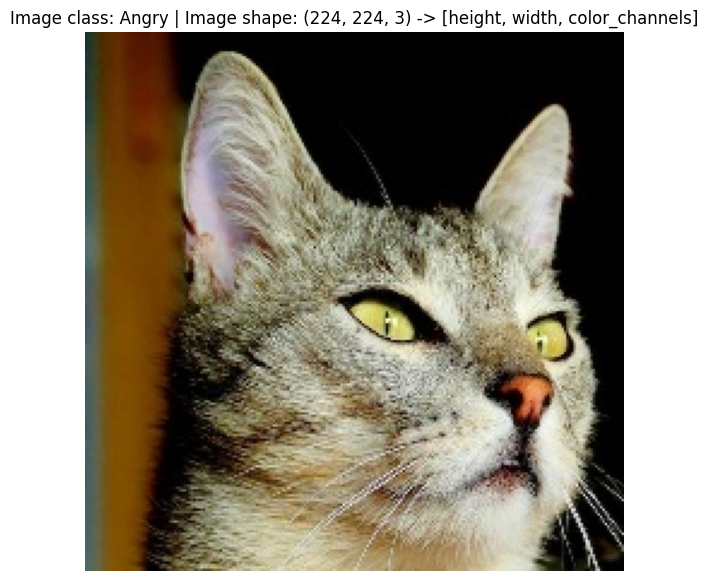

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

image_path = data_path / "animal_data"
# Set seed
random.seed(20) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Question 2
Designing a Convolutional Neural Network

In [5]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

# Define transformations
data_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

# Use torchvision.datasets.ImageFolder to create dataset(s)
from torchvision import datasets

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "valid"


train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: data/animal_expressions/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 36
    Root location: data/animal_expressions/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [6]:
# Checking shape of training data

img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-1.4158, -1.4158, -1.4158,  ..., -1.3473, -1.3302, -1.3302],
         [-1.3987, -1.3987, -1.3987,  ..., -1.3302, -1.3302, -1.3302],
         [-1.3815, -1.3815, -1.3815,  ..., -1.3302, -1.3302, -1.3302],
         ...,
         [ 0.1254,  0.1083,  0.1254,  ...,  0.2453,  0.2453,  0.2453],
         [ 0.1083,  0.0912,  0.1083,  ...,  0.2453,  0.2453,  0.2453],
         [ 0.0741,  0.0569,  0.1083,  ...,  0.2282,  0.2282,  0.2282]],

        [[-0.9678, -0.9678, -0.9678,  ..., -1.0553, -1.0378, -1.0378],
         [-0.9503, -0.9503, -0.9503,  ..., -1.0378, -1.0378, -1.0378],
         [-0.9328, -0.9328, -0.9328,  ..., -1.0378, -1.0378, -1.0378],
         ...,
         [-0.9678, -1.0028, -1.0378,  ...,  0.2927,  0.2927,  0.2927],
         [-1.0028, -1.0203, -1.0553,  ...,  0.2927,  0.2927,  0.2927],
         [-1.0378, -1.0553, -1.0903,  ...,  0.2752,  0.2752,  0.2752]],

        [[-0.5844, -0.5844, -0.5844,  ..., -0.7587, -0.7413, -0.7413],
         [-0.5670, -0.5670, -0.

In [7]:
# Get class names as a list
class_names = train_data.classes
class_names

['Angry', 'Other', 'Sad', 'happy']

In [14]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

# Create iterators for the Data loaded using DataLoader module
batchSize = 4
train_dataloader = DataLoader(dataset=train_data, batch_size=batchSize, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batchSize, num_workers=1, shuffle=False)

In [9]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([4, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([4])


# CNN Model

In [10]:
class CNN(nn.Module):
    def __init__(self): #sequence: input image -> 1st conv -> 1st pool -> 2nd conv -> 2nd pool -> linear layers
        super(CNN, self).__init__() #input image: 224x224x3
        self.conv1 = nn.Conv2d(3, 6, 5) #1st conv: 220x220x6
        self.pool = nn.MaxPool2d(2, 2) #1st pool: 110x110x6, 2nd pool: 53x53x16
        self.conv2 = nn.Conv2d(6, 16, 5) #2nd conv: 106x106x16
        self.fc1 = nn.Linear(53*53*16, 120)
        self.fc2 = nn.Linear(120, 4)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

  c) Define your training loop and train the ConvNet. **(5 marks)**
  



In [16]:
train_data_size = len(train_dataloader.dataset)
test_data_size = len(test_dataloader.dataset)

print(train_data_size)
print(test_data_size)

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)

1000
36


CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=4, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
)

In [17]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

    return history

In [18]:
num_epochs = 10
history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.3855, Accuracy: 28.5000%, 
		Validation : Loss : 1.4211, Accuracy: 19.4444%, Time: 4.4680s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.3365, Accuracy: 36.4000%, 
		Validation : Loss : 1.3470, Accuracy: 36.1111%, Time: 3.0161s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.2408, Accuracy: 43.8000%, 
		Validation : Loss : 1.4111, Accuracy: 25.0000%, Time: 3.8904s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.0380, Accuracy: 57.8000%, 
		Validation : Loss : 1.5055, Accuracy: 27.7778%, Time: 2.9274s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.5689, Accuracy: 79.4000%, 
		Validation : Loss : 2.1205, Accuracy: 25.0000%, Time: 2.9177s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1656, Accuracy: 95.0000%, 
		Validation : Loss : 2.9486, Accuracy: 30.5556%, Time: 2.8823s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1056, Accuracy: 97.3000%, 
		Validation : Loss : 3.8043, Accuracy: 30.5556%, Time: 3.9684s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0998, Accuracy: 97.

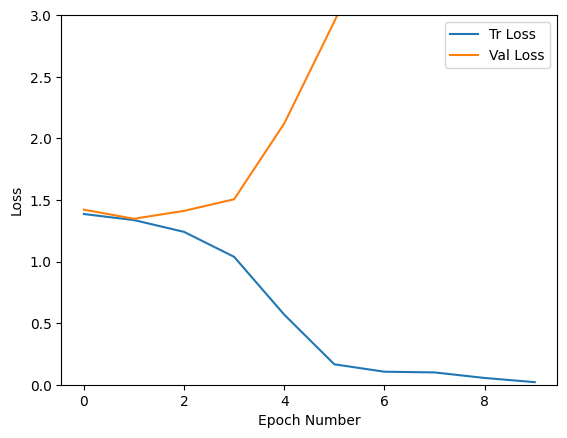

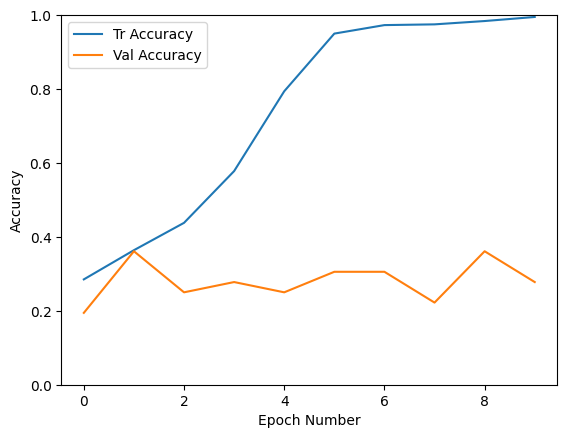

In [19]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

##Question 3
Model shows signs of overfitting, training loss is much lower than validation loss and training accuracy is much higher than validation accuracy.

To reduce overfitting:
1. Data Augmentation is added to increase randomness in dataset
2. Batch Normalisation is added to speed up learning process
3. Dropout is added to prevent model from learning from noise in training dataset

Data Augmentation

In [20]:
data_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

# Use torchvision.datasets.ImageFolder to create dataset(s)
from torchvision import datasets

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "valid"


train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: data/animal_expressions/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 36
    Root location: data/animal_expressions/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
  

In [21]:
batchSize = 4
train_dataloader = DataLoader(dataset=train_data, batch_size=batchSize, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batchSize, num_workers=1, shuffle=False)

In [69]:
class CNN_ver2(nn.Module):
    def __init__(self): #sequence: input image -> 1st conv -> 1st pool -> 2nd conv -> 2nd pool -> linear layers
        super(CNN_ver2, self).__init__() #input image: 224x224x3
        self.conv1 = nn.Conv2d(3, 6, 5) #1st conv: 220x220x6
        self.BN1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2) #1st pool: 110x110x6, 2nd pool: 53x53x16

        self.conv2 = nn.Conv2d(6, 16, 5) #2nd conv: 106x106x16
        self.BN2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(53*53*16, 120)
        self.fc2 = nn.Linear(120, 4)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.BN1(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.BN2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [70]:
train_data_size = len(train_dataloader.dataset)
test_data_size = len(test_dataloader.dataset)

model = CNN_ver2()
# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)

CNN_ver2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=4, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.4, inplace=False)
  (relu): ReLU()
)

In [59]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

    return history

In [60]:
num_epochs = 25
history2 = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 2.3872, Accuracy: 28.0000%, 
		Validation : Loss : 1.4970, Accuracy: 11.1111%, Time: 5.4212s
Epoch: 2/25
Epoch : 001, Training: Loss: 1.3907, Accuracy: 34.0000%, 
		Validation : Loss : 1.2940, Accuracy: 25.0000%, Time: 5.9048s
Epoch: 3/25
Epoch : 002, Training: Loss: 1.3361, Accuracy: 37.4000%, 
		Validation : Loss : 1.5310, Accuracy: 25.0000%, Time: 6.0267s
Epoch: 4/25
Epoch : 003, Training: Loss: 1.2758, Accuracy: 42.7000%, 
		Validation : Loss : 1.4526, Accuracy: 22.2222%, Time: 5.3532s
Epoch: 5/25
Epoch : 004, Training: Loss: 1.2227, Accuracy: 46.2000%, 
		Validation : Loss : 1.3331, Accuracy: 30.5556%, Time: 6.5436s
Epoch: 6/25
Epoch : 005, Training: Loss: 1.1719, Accuracy: 47.6000%, 
		Validation : Loss : 1.4046, Accuracy: 27.7778%, Time: 5.3862s
Epoch: 7/25
Epoch : 006, Training: Loss: 1.1237, Accuracy: 51.4000%, 
		Validation : Loss : 1.5425, Accuracy: 30.5556%, Time: 6.6307s
Epoch: 8/25
Epoch : 007, Training: Loss: 1.0718, Accuracy: 55.

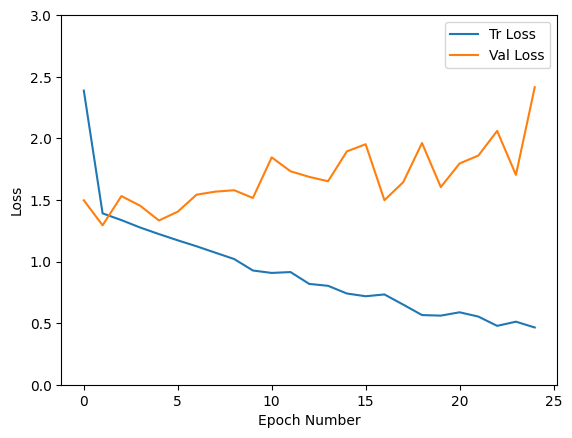

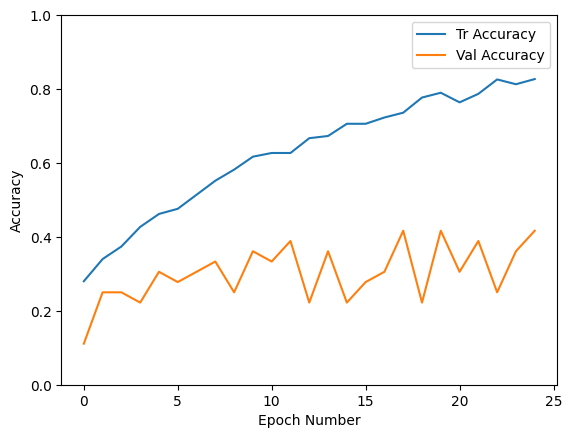

In [61]:
# 5. Analyze the loss curve

history2 = np.array(history2)
plt.plot(history2[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history2[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

##Question 4
Adding Step Decay and Exponential Decay

##Step Decay

In [65]:
from torch.optim.lr_scheduler import StepLR

# added step decay
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        scheduler.step()

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

    return history

In [66]:
# Train the model for 10 epochs

num_epochs = 25
history_sd = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 1.9799, Accuracy: 28.9000%, 
		Validation : Loss : 1.5338, Accuracy: 22.2222%, Time: 5.8546s
Epoch: 2/25
Epoch : 001, Training: Loss: 1.4461, Accuracy: 32.2000%, 
		Validation : Loss : 1.4700, Accuracy: 36.1111%, Time: 6.8422s
Epoch: 3/25
Epoch : 002, Training: Loss: 1.3386, Accuracy: 35.6000%, 
		Validation : Loss : 1.4553, Accuracy: 41.6667%, Time: 6.7037s
Epoch: 4/25
Epoch : 003, Training: Loss: 1.2942, Accuracy: 40.7000%, 
		Validation : Loss : 1.2807, Accuracy: 36.1111%, Time: 6.8387s
Epoch: 5/25
Epoch : 004, Training: Loss: 1.2164, Accuracy: 45.7000%, 
		Validation : Loss : 1.4014, Accuracy: 25.0000%, Time: 6.1189s
Epoch: 6/25
Epoch : 005, Training: Loss: 1.1478, Accuracy: 51.2000%, 
		Validation : Loss : 1.4552, Accuracy: 36.1111%, Time: 7.1113s
Epoch: 7/25
Epoch : 006, Training: Loss: 1.1067, Accuracy: 53.3000%, 
		Validation : Loss : 1.6030, Accuracy: 33.3333%, Time: 5.7018s
Epoch: 8/25
Epoch : 007, Training: Loss: 1.0288, Accuracy: 55.

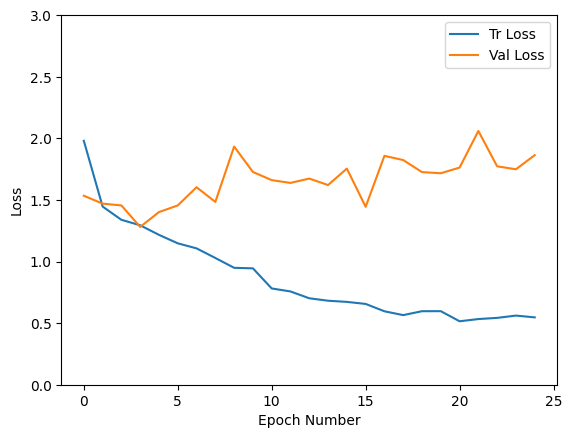

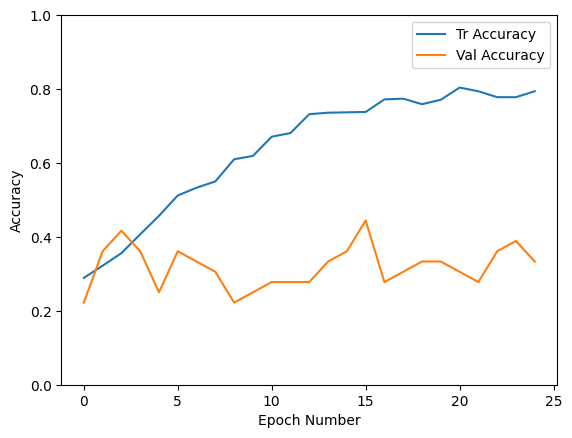

In [67]:
# 5. Analyze the loss curve

history_sd = np.array(history_sd)
plt.plot(history_sd[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history_sd[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [68]:
import pandas as pd

history_sd_df = pd.DataFrame(history_sd)

print(history_sd_df)

           0         1      2         3
0   1.979886  1.533806  0.289  0.222222
1   1.446149  1.469981  0.322  0.361111
2   1.338579  1.455320  0.356  0.416667
3   1.294162  1.280727  0.407  0.361111
4   1.216396  1.401414  0.457  0.250000
5   1.147803  1.455233  0.512  0.361111
6   1.106735  1.602957  0.533  0.333333
7   1.028844  1.483952  0.550  0.305556
8   0.948930  1.932953  0.610  0.222222
9   0.944671  1.726802  0.619  0.250000
10  0.781417  1.660740  0.671  0.277778
11  0.757048  1.638071  0.681  0.277778
12  0.701641  1.673284  0.732  0.277778
13  0.681820  1.620658  0.736  0.333333
14  0.672291  1.754542  0.737  0.361111
15  0.655789  1.444120  0.738  0.444444
16  0.596097  1.857641  0.772  0.277778
17  0.565004  1.823596  0.774  0.305556
18  0.596772  1.725733  0.759  0.333333
19  0.596999  1.716597  0.771  0.333333
20  0.514899  1.762518  0.804  0.305556
21  0.533020  2.059445  0.794  0.277778
22  0.542621  1.772798  0.778  0.361111
23  0.561148  1.748727  0.778  0.388889


##Exponential Decay

In [71]:
from torch.optim.lr_scheduler import ExponentialLR

# added exponential decay
scheduler = ExponentialLR(optimizer, gamma=0.95)

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        scheduler.step()

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

    return history

In [72]:
# Train the model for 10 epochs

num_epochs = 25
history_ed = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 2.2560, Accuracy: 30.4000%, 
		Validation : Loss : 1.8758, Accuracy: 36.1111%, Time: 6.6279s
Epoch: 2/25
Epoch : 001, Training: Loss: 1.4402, Accuracy: 33.4000%, 
		Validation : Loss : 1.3709, Accuracy: 30.5556%, Time: 5.8745s
Epoch: 3/25
Epoch : 002, Training: Loss: 1.3604, Accuracy: 33.6000%, 
		Validation : Loss : 1.4377, Accuracy: 19.4444%, Time: 7.2819s
Epoch: 4/25
Epoch : 003, Training: Loss: 1.3109, Accuracy: 37.6000%, 
		Validation : Loss : 1.5383, Accuracy: 25.0000%, Time: 5.6240s
Epoch: 5/25
Epoch : 004, Training: Loss: 1.2811, Accuracy: 41.7000%, 
		Validation : Loss : 1.3320, Accuracy: 36.1111%, Time: 6.4735s
Epoch: 6/25
Epoch : 005, Training: Loss: 1.2521, Accuracy: 43.9000%, 
		Validation : Loss : 1.4429, Accuracy: 22.2222%, Time: 5.5060s
Epoch: 7/25
Epoch : 006, Training: Loss: 1.1569, Accuracy: 51.8000%, 
		Validation : Loss : 1.4134, Accuracy: 27.7778%, Time: 6.4440s
Epoch: 8/25
Epoch : 007, Training: Loss: 1.0754, Accuracy: 53.

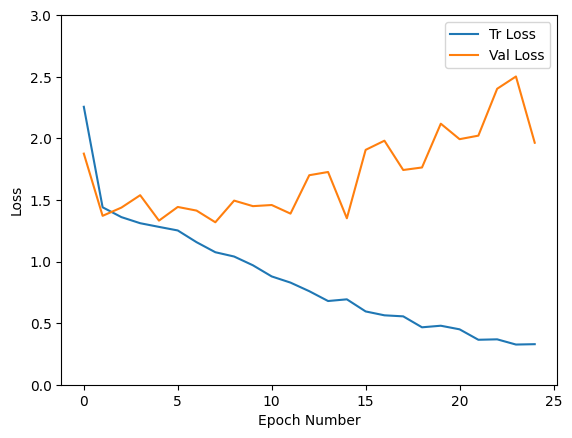

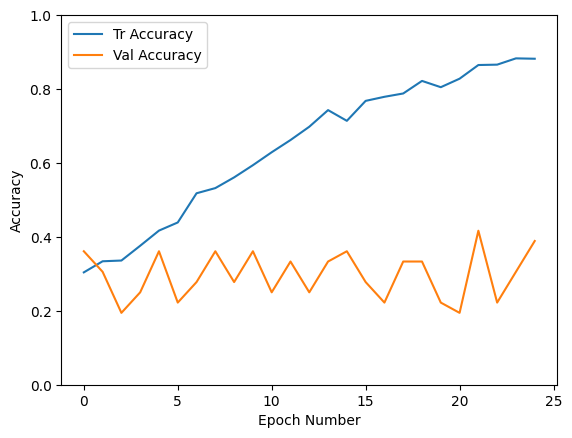

In [73]:
# 5. Analyze the loss curve

history_ed = np.array(history_ed)
plt.plot(history_ed[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history_ed[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [74]:
history_ed_df = pd.DataFrame(history_ed)

print(history_ed_df)

           0         1      2         3
0   2.255964  1.875762  0.304  0.361111
1   1.440165  1.370946  0.334  0.305556
2   1.360431  1.437699  0.336  0.194444
3   1.310938  1.538261  0.376  0.250000
4   1.281123  1.331953  0.417  0.361111
5   1.252135  1.442919  0.439  0.222222
6   1.156942  1.413427  0.518  0.277778
7   1.075411  1.318589  0.532  0.361111
8   1.040534  1.494454  0.561  0.277778
9   0.969475  1.449492  0.594  0.361111
10  0.879002  1.458654  0.629  0.250000
11  0.828859  1.388814  0.662  0.333333
12  0.759138  1.700535  0.698  0.250000
13  0.679418  1.726712  0.743  0.333333
14  0.693124  1.351032  0.714  0.361111
15  0.594882  1.906290  0.768  0.277778
16  0.563351  1.980726  0.779  0.222222
17  0.554936  1.742909  0.788  0.333333
18  0.466079  1.763400  0.822  0.333333
19  0.478839  2.118830  0.805  0.222222
20  0.449633  1.993085  0.828  0.194444
21  0.364872  2.021751  0.865  0.416667
22  0.368415  2.402177  0.866  0.222222
23  0.326113  2.501872  0.883  0.305556


## Question 5

Adding Grouped Convolution and Depthwise Convolution to model

# Grouped Convolution

In [79]:
class CNN_GC(nn.Module):
    def __init__(self): #sequence: input image -> 1st conv -> 1st pool -> 2nd conv -> 2nd pool -> linear layers
        super(CNN_GC, self).__init__() #input image: 224x224x3
        self.conv1 = nn.Conv2d(3, 6, 5) #1st conv: 220x220x6
        self.BN1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2) #1st pool: 110x110x6, 2nd pool: 53x53x16

        self.conv2 = nn.Conv2d(6, 16, 5, groups=2) #2nd conv: 106x106x16, added groups for grouped convolution
        self.BN2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(53*53*16, 120)
        self.fc2 = nn.Linear(120, 4)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.BN1(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.BN2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [80]:
train_data_size = len(train_dataloader.dataset)
test_data_size = len(test_dataloader.dataset)

model = CNN_GC()
# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)

CNN_GC(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), groups=2)
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=4, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [81]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

    return history

In [82]:
num_epochs = 25
history_GC = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 2.3402, Accuracy: 31.2000%, 
		Validation : Loss : 1.4594, Accuracy: 25.0000%, Time: 5.5478s
Epoch: 2/25
Epoch : 001, Training: Loss: 1.4565, Accuracy: 28.2000%, 
		Validation : Loss : 1.3561, Accuracy: 36.1111%, Time: 5.8904s
Epoch: 3/25
Epoch : 002, Training: Loss: 1.3734, Accuracy: 32.2000%, 
		Validation : Loss : 1.3656, Accuracy: 33.3333%, Time: 6.0931s
Epoch: 4/25
Epoch : 003, Training: Loss: 1.3715, Accuracy: 31.3000%, 
		Validation : Loss : 1.4084, Accuracy: 36.1111%, Time: 5.4662s
Epoch: 5/25
Epoch : 004, Training: Loss: 1.3681, Accuracy: 32.2000%, 
		Validation : Loss : 1.4426, Accuracy: 38.8889%, Time: 6.5996s
Epoch: 6/25
Epoch : 005, Training: Loss: 1.3384, Accuracy: 33.2000%, 
		Validation : Loss : 1.3414, Accuracy: 38.8889%, Time: 5.4857s
Epoch: 7/25
Epoch : 006, Training: Loss: 1.3117, Accuracy: 39.5000%, 
		Validation : Loss : 1.5539, Accuracy: 19.4444%, Time: 7.8204s
Epoch: 8/25
Epoch : 007, Training: Loss: 1.3021, Accuracy: 40.

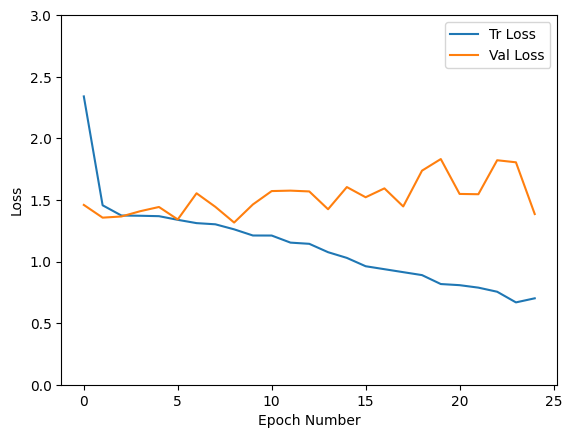

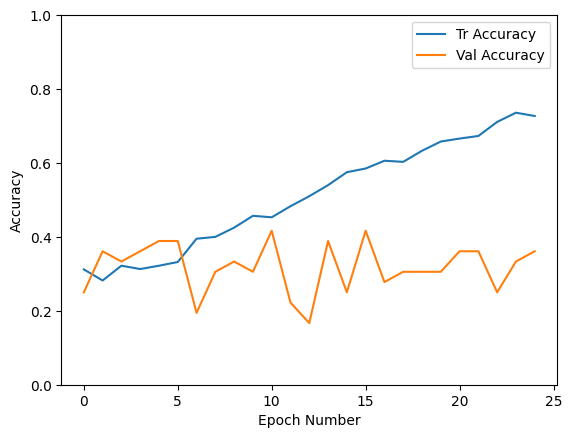

In [83]:
# 5. Analyze the loss curve

history_GC = np.array(history_GC)
plt.plot(history_GC[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history_GC[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

# Depthwise Convolution

In [84]:
class CNN_DC(nn.Module):
    def __init__(self): #sequence: input image -> 1st conv -> 1st pool -> 2nd conv -> 2nd pool -> linear layers
        super(CNN_DC, self).__init__() #input image: 224x224x3
        self.conv1 = nn.Conv2d(3, 6, 5) #1st conv: 220x220x6
        self.BN1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2) #1st pool: 110x110x6, 2nd pool: 53x53x16

        self.conv2 = nn.Conv2d(6, 16, 5, groups=6) #2nd conv: 106x106x16, number of groups = number of input channels giving depthwise convolution
        self.BN2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(53*53*16, 120)
        self.fc2 = nn.Linear(120, 4)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.BN1(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.BN2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [85]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

    return history

In [87]:
num_epochs = 25
history_DC = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 0.6596, Accuracy: 74.1000%, 
		Validation : Loss : 1.5715, Accuracy: 36.1111%, Time: 5.4910s
Epoch: 2/25
Epoch : 001, Training: Loss: 0.6122, Accuracy: 74.2000%, 
		Validation : Loss : 2.0122, Accuracy: 27.7778%, Time: 6.5841s
Epoch: 3/25
Epoch : 002, Training: Loss: 0.5962, Accuracy: 77.1000%, 
		Validation : Loss : 2.2861, Accuracy: 30.5556%, Time: 5.5102s
Epoch: 4/25
Epoch : 003, Training: Loss: 0.5729, Accuracy: 77.6000%, 
		Validation : Loss : 2.1971, Accuracy: 33.3333%, Time: 6.5345s
Epoch: 5/25
Epoch : 004, Training: Loss: 0.5721, Accuracy: 78.3000%, 
		Validation : Loss : 2.2823, Accuracy: 36.1111%, Time: 5.4850s
Epoch: 6/25
Epoch : 005, Training: Loss: 0.5634, Accuracy: 78.8000%, 
		Validation : Loss : 2.0951, Accuracy: 38.8889%, Time: 6.5739s
Epoch: 7/25
Epoch : 006, Training: Loss: 0.5329, Accuracy: 78.9000%, 
		Validation : Loss : 1.7784, Accuracy: 33.3333%, Time: 5.4340s
Epoch: 8/25
Epoch : 007, Training: Loss: 0.5057, Accuracy: 81.

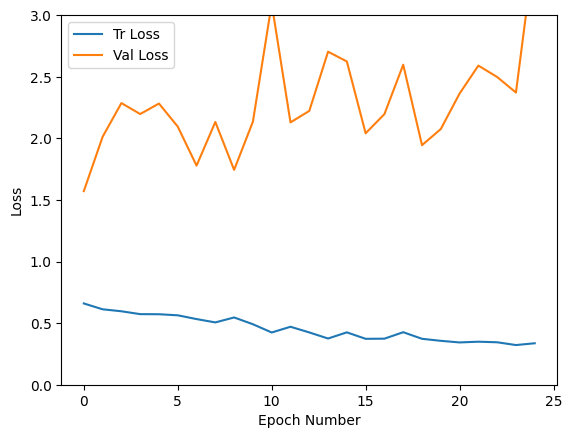

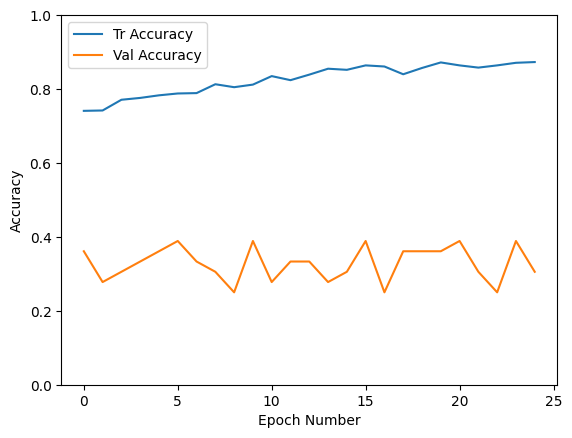

In [88]:
# 5. Analyze the loss curve

history_DC = np.array(history_DC)
plt.plot(history_DC[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history_DC[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

## Question 6

Use a pre-trained model

In [90]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [98]:
model = models.resnet18(weights='DEFAULT')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [99]:
num_ftrs = model.fc.in_features
# The size of each output sample is set to 4.
model.fc = nn.Linear(num_ftrs, len(class_names))

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [100]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

    return history

In [101]:
num_epochs = 10
history_final = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.5937, Accuracy: 25.1000%, 
		Validation : Loss : 1.8204, Accuracy: 16.6667%, Time: 7.7787s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.5871, Accuracy: 25.3000%, 
		Validation : Loss : 1.6748, Accuracy: 19.4444%, Time: 6.5132s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.6017, Accuracy: 24.9000%, 
		Validation : Loss : 1.7162, Accuracy: 16.6667%, Time: 7.6537s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.5854, Accuracy: 25.2000%, 
		Validation : Loss : 1.7340, Accuracy: 16.6667%, Time: 7.1814s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.5899, Accuracy: 26.6000%, 
		Validation : Loss : 1.7724, Accuracy: 22.2222%, Time: 6.8855s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.6023, Accuracy: 26.0000%, 
		Validation : Loss : 1.7658, Accuracy: 16.6667%, Time: 7.6751s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.6046, Accuracy: 25.1000%, 
		Validation : Loss : 1.8169, Accuracy: 16.6667%, Time: 6.4360s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.5997, Accuracy: 23.

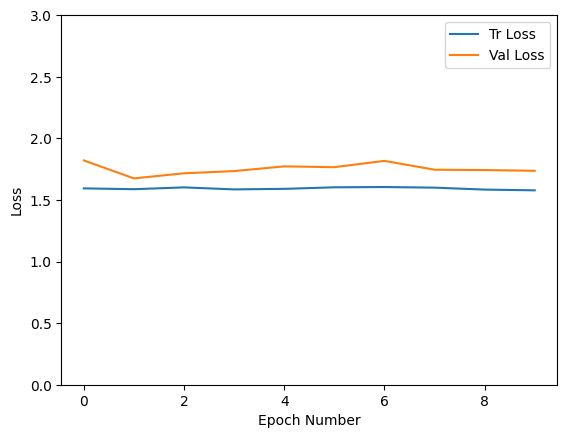

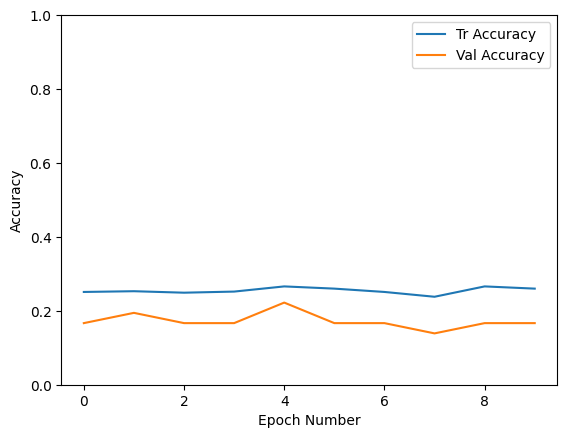

In [102]:
# 5. Analyze the loss curve

history_final = np.array(history_final)
plt.plot(history_final[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history_final[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()